In [5]:
# https://github.com/quantumlib/OpenFermion-Psi4/blob/master/examples/openfermionpsi4_demo.ipynb

from openfermion.hamiltonians import MolecularData
from openfermionpsi4 import run_psi4
import matplotlib.pyplot as plt
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
from qutip import *
import numpy as np
import h5py
from tqdm import tqdm

In [21]:
def save_hamiltonian(qf_ham, filename):
    ham = get_sparse_operator(qf_ham).todense()
    with h5py.File("hamiltonians/" + filename, "w") as f:
        dset = f.create_dataset("hamiltonian", data=ham)
        
def gen_eigenstates(qf_hamiltonians):
    groundenergies = []
    groundstates = []
    for qf_ham in qf_hamiltonians:
        ham = Qobj(get_sparse_operator(qf_ham).todense())
        eigenstates = ham.eigenstates()
        i = np.argmin(eigenstates[0])
        groundenergy, groundstate = eigenstates[0][i], eigenstates[1][i]
        groundenergies += [groundenergy]
        groundstates += [groundstates]
    return groundenergies, groundstates

In [18]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.06
n_points = 50

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
hamiltonians = []
n_qubitss = []
for point in tqdm(range(1, n_points + 1)):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)),
        filename="data/{}.{}".format(basis, np.round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_psi4(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

    # Print out some results of calculation.
    n_qubitss += [molecule.n_qubits]
    hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian = jordan_wigner(get_fermion_operator(hamiltonian))
    hamiltonians += [hamiltonian]
    
    # Save hamiltonians to disk
    save_hamiltonian(hamiltonian, "{}.{}.hdf5".format(basis, np.round(bond_length, 2)))
    

100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


In [22]:
groundenergies, groundstates = gen_eigenstates(hamiltonians)

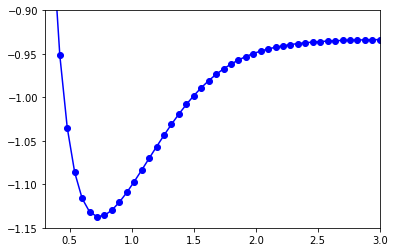

In [23]:
plt.plot(bond_lengths, groundenergies, 'bo-')
plt.ylim([-1.15, -0.90])
plt.xlim([0.3, 3.0])
plt.show()

In [24]:
with h5py.File("bond_lengths.hdf5", "w") as f:
    dset = f.create_dataset("bond_lengths", data=bond_lengths)

In [55]:
# # Self-implementation
# letter_to_op = {
#     'X':sigmax(),
#     'Y':sigmay(),
#     'Z':sigmaz()
# }

# def makepaulin(n, info):
#     tgt, l = info
#     op = letter_to_op[l]
#     tmp = [qeye(2) for _ in range(n)]
#     tmp[tgt] = op
#     return tensor(tmp)

# def multipaulin(n, lstinfo):
#     res = qeye([2] * n)
#     for info in lstinfo:
#         res *= makepaulin(n, info)
#     return res

# def ham_to_op(n, of_hamiltonian):
#     terms = of_hamiltonian.terms
    
#     # generate zeroed operator of correct dimensions
#     op = tenseye(n) - tenseye(n)
    
#     # iterate through terms of hamiltonian
#     for key in list(terms.keys()):
#         if not key:
#             op += qeye([2] * n) * terms[key]
#         else:
#             # coefficient * product of operators
#             op += terms[key] * multipaulin(n, key)
#     return op